# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

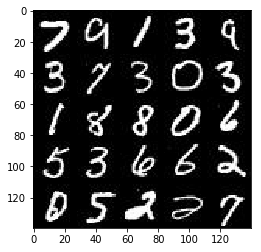

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

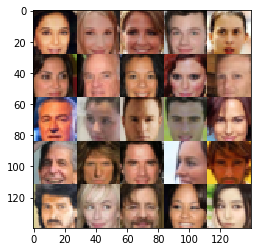

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = "real_input")
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
#global hyperparams for dropout
keep_prob_generator = 0.5
keep_prob_discriminator = 0.5

In [15]:
#global leaky relu hyperparam
leaky_relu_value = 0.2

#global leaky relu helper function
def lrelu(x, name="lrelu"):
    return tf.maximum(x, leaky_relu_value * x, name=name)

In [14]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope("discriminator",reuse=reuse):
        #alpha=0.2

        l1 = tf.layers.conv2d(images, 
                              64, 
                              5, 
                              strides=2, 
                              padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))
        l1 = tf.layers.dropout(l1, rate=0.5, training=True)
        l1 = lrelu(l1)

        l2 = tf.layers.conv2d(l1,
                              128, 
                              5, 
                              strides=2, 
                              padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))

        l2 = tf.layers.dropout(l2, rate=0.5, training=True)
        l2 = tf.layers.batch_normalization(l2,training=True)
        l2 = lrelu(l2)
        
        l3 = tf.layers.conv2d(l2, 
                              256, 
                              5, 
                              strides=2, 
                              padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))

        l3 = tf.layers.dropout(l3, rate=keep_prob_discriminator, training=True)
        l3 = tf.layers.batch_normalization(l2,training=True)
        l3 = lrelu(l3)
        
        flat = tf.reshape(l2, (-1,7*7*256))
        
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [16]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """

    reuse = not is_train
    
    with tf.variable_scope("generator", reuse=reuse):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = lrelu(x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 
                                        256, 
                                        4, 
                                        strides=1, 
                                        padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))
        x2 = tf.layers.dropout(x2, keep_prob_generator, training=is_train)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = lrelu(x2)

        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 
                                        128, 
                                        4, 
                                        strides=2, 
                                        padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))
        x3 = tf.layers.dropout(x3, keep_prob_generator, training=is_train)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = lrelu(x3)

        # 14x14x128 now

        # 28x28x(out_channel_dimension) now
        logits = tf.layers.conv2d_transpose(x3, 
                                            out_channel_dim, 
                                            5, 
                                            strides=2, 
                                            padding='same')
        return tf.tanh(logits)



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [17]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # get counterfit from generator, 
    # get output from discriminator using real input
    # get output from discriminator using counterfit generated
    g_out = generator(input_z,out_channel_dim=out_channel_dim)
    d_real_out, d_real_logit = discriminator(input_real)
    d_fake_out, d_fake_logit = discriminator(g_out,reuse=True)
    
    #real label smoothing
    smooth = 0.1
    
    # shortcut loss calculation function
    calculate_loss = lambda logits,labels : tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=labels))
    
    real_label = tf.ones_like(d_real_out) * (1 - smooth)
    fake_label = tf.zeros_like(d_fake_out)
    
    d_loss_real = calculate_loss(d_real_logit, real_label)
    d_loss_fake = calculate_loss(d_fake_logit, fake_label)
    
    g_loss = calculate_loss(d_fake_logit, tf.ones_like(d_fake_out))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [18]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # get variables for `var_list` minimize parameter
    trainables = tf.trainable_variables()

    # filter those by generator/discriminator
    gen_train = [operation for operation in trainables if operation.name.startswith('generator')]
    dis_train = [operation for operation in trainables if operation.name.startswith('discriminator')]

    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    # use with control dependencies for batch normalization calculations updating
    with tf.control_dependencies(g_update_ops):
        # calculate optimizations
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss,var_list=gen_train)

    # use with control dependencies for batch normalization calculations updating
    with tf.control_dependencies(d_update_ops):
        # calculate optimizations
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss,var_list=dis_train)
        
    return g_train_opt, d_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:
import datetime


def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    
    real_input, z_input, lr = model_inputs(data_shape[1],
                                           data_shape[2], 
                                           data_shape[3], 
                                           z_dim)
    
    d_loss, g_loss = model_loss(real_input, 
                                z_input, 
                                data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss,
                             g_loss,
                             learning_rate,
                             beta1)
    
    steps, step_text_update, step_example_update = 0, 10, 100
    sample_size = 25
    display_count, display_max_count = 0,31
    
    #calculates how many images outputs will occur
    max_multiplier = 64/batch_size
    display_max_count *= max_multiplier
    
    #debug calculate start time
    start = datetime.datetime.now()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps+=1
                
                # resize b/c we used -.5 to .5 instead of -1 to 1
                batch_images = batch_images * 2
                
                # random sample noise 
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #run optimizers
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: batch_z})
                _ = sess.run(g_opt, feed_dict={z_input: batch_z, lr: learning_rate, real_input: batch_images})
#                 #run twice to speed up generator training
#                 _ = sess.run(g_opt, feed_dict={z_input: batch_z, lr: learning_rate, real_input: batch_images})
                
                if steps % step_text_update == 0:
                    train_loss_d = d_loss.eval({z_input: batch_z, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})

                    print("epoch {}/{} ***".format(epoch_i+1, epochs),
                          "discriminator loss: {:.4f} ***".format(train_loss_d),
                          "generator loss: {:.4f}".format(train_loss_g))                    
                
                if steps % step_example_update == 0:
                    display_count += 1
                    print("progress: {0:.0f}%".format(display_count/display_max_count * 100))
                    show_generator_output(sess, sample_size, z_input, data_shape[3], data_image_mode)
                    
    #Debug calculate total time taken
    end = datetime.datetime.now()
    dif = end - start
    time_taken = divmod(dif.days * 86400 + dif.seconds, 60)
    print(time_taken)
    print("COMPLETE")

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

epoch 1/2 *** discriminator loss: 1.4671 *** generator loss: 1.6160
epoch 1/2 *** discriminator loss: 1.5746 *** generator loss: 0.8975
epoch 1/2 *** discriminator loss: 1.0690 *** generator loss: 0.9231
epoch 1/2 *** discriminator loss: 0.9709 *** generator loss: 1.3726
epoch 1/2 *** discriminator loss: 1.5397 *** generator loss: 2.4354
epoch 1/2 *** discriminator loss: 1.4311 *** generator loss: 1.7084
epoch 1/2 *** discriminator loss: 1.1945 *** generator loss: 1.6719
epoch 1/2 *** discriminator loss: 1.2177 *** generator loss: 1.4287
epoch 1/2 *** discriminator loss: 1.4236 *** generator loss: 1.0778
epoch 1/2 *** discriminator loss: 1.5580 *** generator loss: 0.3998
progress: 2%


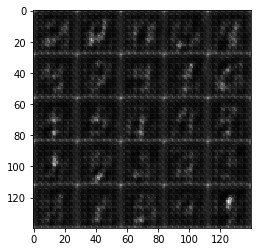

epoch 1/2 *** discriminator loss: 1.4662 *** generator loss: 0.9267
epoch 1/2 *** discriminator loss: 1.3486 *** generator loss: 1.0905
epoch 1/2 *** discriminator loss: 1.6295 *** generator loss: 1.7449
epoch 1/2 *** discriminator loss: 1.3899 *** generator loss: 1.0489
epoch 1/2 *** discriminator loss: 1.3642 *** generator loss: 1.3256
epoch 1/2 *** discriminator loss: 1.4825 *** generator loss: 0.8777
epoch 1/2 *** discriminator loss: 1.5938 *** generator loss: 1.5201
epoch 1/2 *** discriminator loss: 1.2381 *** generator loss: 0.9725
epoch 1/2 *** discriminator loss: 1.2622 *** generator loss: 0.6107
epoch 1/2 *** discriminator loss: 1.0854 *** generator loss: 1.1745
progress: 3%


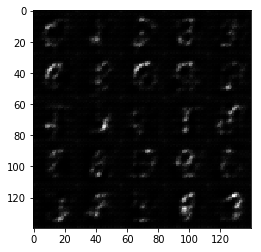

epoch 1/2 *** discriminator loss: 1.9418 *** generator loss: 2.5783
epoch 1/2 *** discriminator loss: 1.4193 *** generator loss: 0.8067
epoch 1/2 *** discriminator loss: 1.4570 *** generator loss: 2.0044
epoch 1/2 *** discriminator loss: 1.3919 *** generator loss: 0.8291
epoch 1/2 *** discriminator loss: 1.0425 *** generator loss: 0.9522
epoch 1/2 *** discriminator loss: 1.1164 *** generator loss: 1.0989
epoch 1/2 *** discriminator loss: 1.2998 *** generator loss: 1.8061
epoch 1/2 *** discriminator loss: 1.3268 *** generator loss: 1.0929
epoch 1/2 *** discriminator loss: 1.3855 *** generator loss: 1.2955
epoch 1/2 *** discriminator loss: 1.3174 *** generator loss: 0.5680
progress: 5%


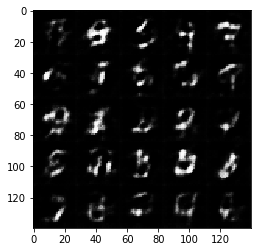

epoch 1/2 *** discriminator loss: 1.3048 *** generator loss: 1.6636
epoch 1/2 *** discriminator loss: 1.2506 *** generator loss: 1.4653
epoch 1/2 *** discriminator loss: 1.3005 *** generator loss: 1.6013
epoch 1/2 *** discriminator loss: 1.3124 *** generator loss: 0.8109
epoch 1/2 *** discriminator loss: 1.2016 *** generator loss: 1.2517
epoch 1/2 *** discriminator loss: 1.6467 *** generator loss: 0.3564
epoch 1/2 *** discriminator loss: 1.6989 *** generator loss: 1.9236
epoch 1/2 *** discriminator loss: 1.1428 *** generator loss: 1.4835
epoch 1/2 *** discriminator loss: 1.2556 *** generator loss: 1.7431
epoch 1/2 *** discriminator loss: 1.1776 *** generator loss: 1.1481
progress: 6%


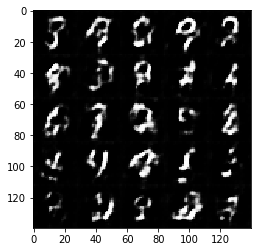

epoch 1/2 *** discriminator loss: 1.3628 *** generator loss: 0.6140
epoch 1/2 *** discriminator loss: 1.2152 *** generator loss: 0.8017
epoch 1/2 *** discriminator loss: 1.3919 *** generator loss: 1.3980
epoch 1/2 *** discriminator loss: 1.4803 *** generator loss: 1.6599
epoch 1/2 *** discriminator loss: 1.4925 *** generator loss: 0.7521
epoch 1/2 *** discriminator loss: 1.3567 *** generator loss: 0.6539
epoch 1/2 *** discriminator loss: 1.4777 *** generator loss: 0.4581
epoch 1/2 *** discriminator loss: 1.3408 *** generator loss: 0.6393
epoch 1/2 *** discriminator loss: 1.3038 *** generator loss: 0.6848
epoch 1/2 *** discriminator loss: 1.2048 *** generator loss: 1.1719
progress: 8%


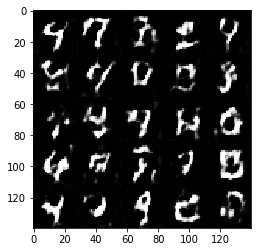

epoch 1/2 *** discriminator loss: 1.1700 *** generator loss: 1.3246
epoch 1/2 *** discriminator loss: 1.2715 *** generator loss: 0.9029
epoch 1/2 *** discriminator loss: 1.2195 *** generator loss: 1.6867
epoch 1/2 *** discriminator loss: 1.5150 *** generator loss: 2.2470
epoch 1/2 *** discriminator loss: 1.1926 *** generator loss: 1.2033
epoch 1/2 *** discriminator loss: 1.3734 *** generator loss: 0.6758
epoch 1/2 *** discriminator loss: 1.3815 *** generator loss: 1.2253
epoch 1/2 *** discriminator loss: 1.2676 *** generator loss: 0.6016
epoch 1/2 *** discriminator loss: 1.4986 *** generator loss: 1.6763
epoch 1/2 *** discriminator loss: 1.1770 *** generator loss: 1.3790
progress: 10%


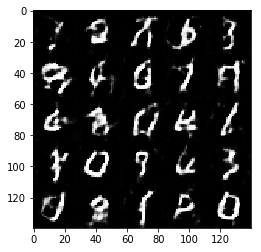

epoch 1/2 *** discriminator loss: 1.2019 *** generator loss: 1.4087
epoch 1/2 *** discriminator loss: 1.3304 *** generator loss: 1.2411
epoch 1/2 *** discriminator loss: 1.5943 *** generator loss: 0.4975
epoch 1/2 *** discriminator loss: 1.2663 *** generator loss: 0.9265
epoch 1/2 *** discriminator loss: 1.3126 *** generator loss: 1.2475
epoch 1/2 *** discriminator loss: 1.2750 *** generator loss: 0.9567
epoch 1/2 *** discriminator loss: 1.2259 *** generator loss: 0.9150
epoch 1/2 *** discriminator loss: 1.2096 *** generator loss: 0.9209
epoch 1/2 *** discriminator loss: 1.1317 *** generator loss: 1.0974
epoch 1/2 *** discriminator loss: 1.3422 *** generator loss: 1.3984
progress: 11%


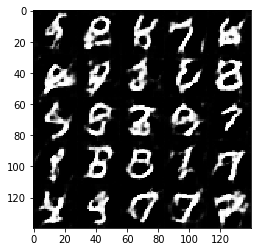

epoch 1/2 *** discriminator loss: 1.3372 *** generator loss: 0.7783
epoch 1/2 *** discriminator loss: 1.2593 *** generator loss: 1.2201
epoch 1/2 *** discriminator loss: 1.2335 *** generator loss: 0.9393
epoch 1/2 *** discriminator loss: 1.1065 *** generator loss: 0.7433
epoch 1/2 *** discriminator loss: 1.0798 *** generator loss: 1.2341
epoch 1/2 *** discriminator loss: 1.1654 *** generator loss: 1.0516
epoch 1/2 *** discriminator loss: 1.4050 *** generator loss: 1.5048
epoch 1/2 *** discriminator loss: 1.4985 *** generator loss: 0.5748
epoch 1/2 *** discriminator loss: 1.2942 *** generator loss: 1.4229
epoch 1/2 *** discriminator loss: 1.1804 *** generator loss: 1.0125
progress: 13%


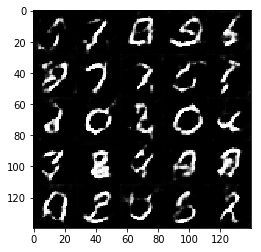

epoch 1/2 *** discriminator loss: 1.3075 *** generator loss: 1.1259
epoch 1/2 *** discriminator loss: 1.3515 *** generator loss: 0.6843
epoch 1/2 *** discriminator loss: 1.2408 *** generator loss: 1.0935
epoch 1/2 *** discriminator loss: 1.3482 *** generator loss: 1.0325
epoch 1/2 *** discriminator loss: 1.0058 *** generator loss: 0.9295
epoch 1/2 *** discriminator loss: 1.3243 *** generator loss: 0.7460
epoch 1/2 *** discriminator loss: 1.1865 *** generator loss: 0.9858
epoch 1/2 *** discriminator loss: 1.4144 *** generator loss: 1.2584
epoch 1/2 *** discriminator loss: 1.2358 *** generator loss: 1.0550
epoch 1/2 *** discriminator loss: 1.2917 *** generator loss: 0.8717
progress: 15%


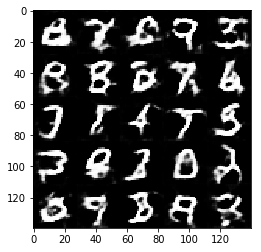

epoch 1/2 *** discriminator loss: 1.3316 *** generator loss: 0.9089
epoch 1/2 *** discriminator loss: 1.2377 *** generator loss: 1.1089
epoch 1/2 *** discriminator loss: 1.3510 *** generator loss: 1.2125
epoch 1/2 *** discriminator loss: 1.2624 *** generator loss: 1.0123
epoch 1/2 *** discriminator loss: 1.2411 *** generator loss: 0.9326
epoch 1/2 *** discriminator loss: 1.3699 *** generator loss: 1.6424
epoch 1/2 *** discriminator loss: 1.4158 *** generator loss: 0.8287
epoch 1/2 *** discriminator loss: 1.1595 *** generator loss: 1.2941
epoch 1/2 *** discriminator loss: 1.3116 *** generator loss: 1.5743
epoch 1/2 *** discriminator loss: 1.2799 *** generator loss: 1.2270
progress: 16%


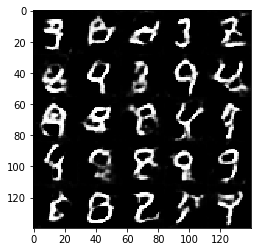

epoch 1/2 *** discriminator loss: 1.4484 *** generator loss: 0.9362
epoch 1/2 *** discriminator loss: 1.3043 *** generator loss: 1.0184
epoch 1/2 *** discriminator loss: 1.2877 *** generator loss: 1.0991
epoch 1/2 *** discriminator loss: 1.2618 *** generator loss: 0.9614
epoch 1/2 *** discriminator loss: 1.1668 *** generator loss: 0.9985
epoch 1/2 *** discriminator loss: 1.2092 *** generator loss: 1.2846
epoch 1/2 *** discriminator loss: 1.2637 *** generator loss: 1.2693
epoch 1/2 *** discriminator loss: 1.1245 *** generator loss: 1.2151
epoch 1/2 *** discriminator loss: 1.4118 *** generator loss: 0.9132
epoch 1/2 *** discriminator loss: 1.4148 *** generator loss: 0.9482
progress: 18%


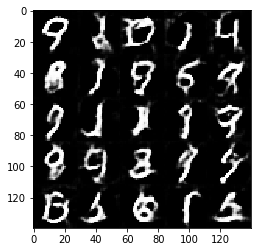

epoch 1/2 *** discriminator loss: 1.1150 *** generator loss: 1.1060
epoch 1/2 *** discriminator loss: 1.3155 *** generator loss: 1.4157
epoch 1/2 *** discriminator loss: 1.2569 *** generator loss: 1.2441
epoch 1/2 *** discriminator loss: 1.2054 *** generator loss: 1.3470
epoch 1/2 *** discriminator loss: 1.2561 *** generator loss: 0.7996
epoch 1/2 *** discriminator loss: 1.2995 *** generator loss: 1.0644
epoch 1/2 *** discriminator loss: 1.5568 *** generator loss: 1.6529
epoch 1/2 *** discriminator loss: 1.3540 *** generator loss: 1.0335
epoch 1/2 *** discriminator loss: 1.2164 *** generator loss: 1.4190
epoch 1/2 *** discriminator loss: 1.3529 *** generator loss: 1.3860
progress: 19%


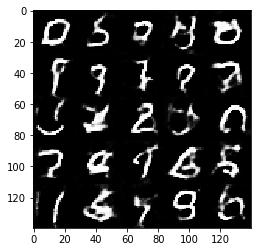

epoch 1/2 *** discriminator loss: 1.2768 *** generator loss: 1.0609
epoch 1/2 *** discriminator loss: 1.2798 *** generator loss: 0.6264
epoch 1/2 *** discriminator loss: 1.2682 *** generator loss: 1.0188
epoch 1/2 *** discriminator loss: 1.3930 *** generator loss: 0.6823
epoch 1/2 *** discriminator loss: 1.2199 *** generator loss: 1.2461
epoch 1/2 *** discriminator loss: 1.0341 *** generator loss: 0.9835
epoch 1/2 *** discriminator loss: 1.5044 *** generator loss: 1.3875
epoch 1/2 *** discriminator loss: 1.2057 *** generator loss: 0.9067
epoch 1/2 *** discriminator loss: 1.5025 *** generator loss: 0.5225
epoch 1/2 *** discriminator loss: 1.1533 *** generator loss: 1.1066
progress: 21%


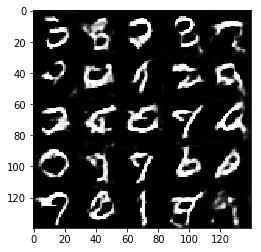

epoch 1/2 *** discriminator loss: 1.4942 *** generator loss: 0.9109
epoch 1/2 *** discriminator loss: 1.3444 *** generator loss: 1.0061
epoch 1/2 *** discriminator loss: 1.1575 *** generator loss: 0.9725
epoch 1/2 *** discriminator loss: 1.1177 *** generator loss: 1.5442
epoch 1/2 *** discriminator loss: 1.3256 *** generator loss: 0.7256
epoch 1/2 *** discriminator loss: 1.3621 *** generator loss: 1.7371
epoch 1/2 *** discriminator loss: 1.2322 *** generator loss: 0.9759
epoch 1/2 *** discriminator loss: 1.1785 *** generator loss: 0.9884
epoch 1/2 *** discriminator loss: 1.3008 *** generator loss: 0.8278
epoch 1/2 *** discriminator loss: 1.3159 *** generator loss: 0.5787
progress: 23%


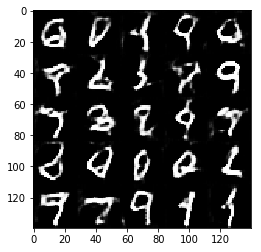

epoch 1/2 *** discriminator loss: 1.3154 *** generator loss: 0.6671
epoch 1/2 *** discriminator loss: 1.4497 *** generator loss: 0.5999
epoch 1/2 *** discriminator loss: 1.2719 *** generator loss: 0.7672
epoch 1/2 *** discriminator loss: 1.2051 *** generator loss: 1.1166
epoch 1/2 *** discriminator loss: 1.3116 *** generator loss: 0.8612
epoch 1/2 *** discriminator loss: 1.2164 *** generator loss: 1.1250
epoch 1/2 *** discriminator loss: 1.5163 *** generator loss: 0.4417
epoch 1/2 *** discriminator loss: 1.4485 *** generator loss: 0.9777
epoch 1/2 *** discriminator loss: 1.3362 *** generator loss: 1.1881
epoch 1/2 *** discriminator loss: 1.2401 *** generator loss: 1.3163
progress: 24%


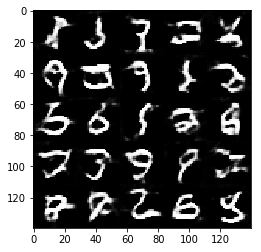

epoch 1/2 *** discriminator loss: 1.4510 *** generator loss: 0.7087
epoch 1/2 *** discriminator loss: 1.0861 *** generator loss: 1.0593
epoch 1/2 *** discriminator loss: 1.4430 *** generator loss: 0.7576
epoch 1/2 *** discriminator loss: 1.2664 *** generator loss: 1.2857
epoch 1/2 *** discriminator loss: 1.1268 *** generator loss: 1.0973
epoch 1/2 *** discriminator loss: 1.2253 *** generator loss: 1.3400
epoch 1/2 *** discriminator loss: 1.4009 *** generator loss: 0.9748
epoch 1/2 *** discriminator loss: 1.5084 *** generator loss: 0.7010
epoch 1/2 *** discriminator loss: 1.2979 *** generator loss: 1.3736
epoch 1/2 *** discriminator loss: 1.3175 *** generator loss: 1.7747
progress: 26%


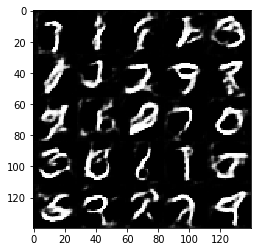

epoch 1/2 *** discriminator loss: 1.0318 *** generator loss: 1.1119
epoch 1/2 *** discriminator loss: 1.4278 *** generator loss: 1.5844
epoch 1/2 *** discriminator loss: 1.3320 *** generator loss: 0.8407
epoch 1/2 *** discriminator loss: 1.1218 *** generator loss: 1.0497
epoch 1/2 *** discriminator loss: 0.9670 *** generator loss: 1.1542
epoch 1/2 *** discriminator loss: 1.2084 *** generator loss: 1.2913
epoch 1/2 *** discriminator loss: 1.3490 *** generator loss: 0.8597
epoch 1/2 *** discriminator loss: 1.2311 *** generator loss: 0.9192
epoch 1/2 *** discriminator loss: 1.2974 *** generator loss: 0.8074
epoch 1/2 *** discriminator loss: 1.0969 *** generator loss: 1.1148
progress: 27%


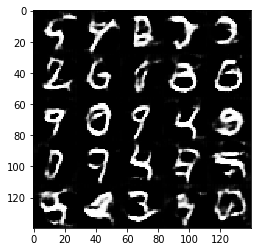

epoch 1/2 *** discriminator loss: 1.2333 *** generator loss: 1.2736
epoch 1/2 *** discriminator loss: 1.5182 *** generator loss: 0.7849
epoch 1/2 *** discriminator loss: 1.2272 *** generator loss: 1.0671
epoch 1/2 *** discriminator loss: 1.2902 *** generator loss: 1.4358
epoch 1/2 *** discriminator loss: 1.0868 *** generator loss: 1.1094
epoch 1/2 *** discriminator loss: 1.1581 *** generator loss: 0.8627
epoch 1/2 *** discriminator loss: 1.1560 *** generator loss: 1.3772
epoch 1/2 *** discriminator loss: 1.1747 *** generator loss: 1.2904
epoch 1/2 *** discriminator loss: 1.1477 *** generator loss: 1.1141
epoch 1/2 *** discriminator loss: 1.4902 *** generator loss: 0.7940
progress: 29%


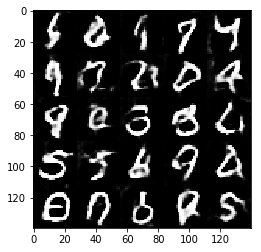

epoch 1/2 *** discriminator loss: 1.0850 *** generator loss: 0.9536
epoch 1/2 *** discriminator loss: 1.1068 *** generator loss: 1.1584
epoch 1/2 *** discriminator loss: 1.3583 *** generator loss: 1.1682
epoch 1/2 *** discriminator loss: 1.3395 *** generator loss: 1.1409
epoch 1/2 *** discriminator loss: 1.2220 *** generator loss: 1.0426
epoch 1/2 *** discriminator loss: 1.3033 *** generator loss: 1.3783
epoch 1/2 *** discriminator loss: 1.4500 *** generator loss: 0.5878
epoch 2/2 *** discriminator loss: 1.2228 *** generator loss: 1.2960
epoch 2/2 *** discriminator loss: 1.1756 *** generator loss: 1.4544
epoch 2/2 *** discriminator loss: 1.1508 *** generator loss: 1.4836
progress: 31%


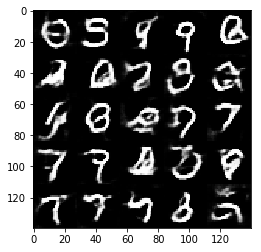

epoch 2/2 *** discriminator loss: 1.6549 *** generator loss: 0.7715
epoch 2/2 *** discriminator loss: 1.1895 *** generator loss: 1.3255
epoch 2/2 *** discriminator loss: 1.4851 *** generator loss: 1.5939
epoch 2/2 *** discriminator loss: 1.1603 *** generator loss: 0.9345
epoch 2/2 *** discriminator loss: 1.2080 *** generator loss: 1.0484
epoch 2/2 *** discriminator loss: 1.1744 *** generator loss: 1.1778
epoch 2/2 *** discriminator loss: 1.3253 *** generator loss: 0.9997
epoch 2/2 *** discriminator loss: 1.1713 *** generator loss: 0.9901
epoch 2/2 *** discriminator loss: 1.2161 *** generator loss: 0.6231
epoch 2/2 *** discriminator loss: 1.3632 *** generator loss: 1.0398
progress: 32%


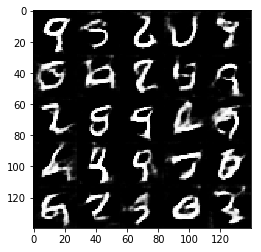

epoch 2/2 *** discriminator loss: 1.1290 *** generator loss: 1.2678
epoch 2/2 *** discriminator loss: 1.2245 *** generator loss: 0.9408
epoch 2/2 *** discriminator loss: 1.1124 *** generator loss: 1.1632
epoch 2/2 *** discriminator loss: 1.1611 *** generator loss: 1.0998
epoch 2/2 *** discriminator loss: 1.2662 *** generator loss: 1.0740
epoch 2/2 *** discriminator loss: 1.0414 *** generator loss: 0.8763
epoch 2/2 *** discriminator loss: 1.0729 *** generator loss: 1.0797
epoch 2/2 *** discriminator loss: 1.1503 *** generator loss: 0.9597
epoch 2/2 *** discriminator loss: 1.3111 *** generator loss: 1.9439
epoch 2/2 *** discriminator loss: 1.1361 *** generator loss: 1.1310
progress: 34%


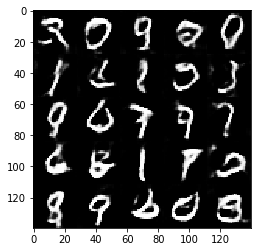

epoch 2/2 *** discriminator loss: 1.1665 *** generator loss: 1.2315
epoch 2/2 *** discriminator loss: 1.3273 *** generator loss: 1.4584
epoch 2/2 *** discriminator loss: 1.2025 *** generator loss: 1.1356
epoch 2/2 *** discriminator loss: 1.0762 *** generator loss: 0.9409
epoch 2/2 *** discriminator loss: 1.2473 *** generator loss: 1.7117
epoch 2/2 *** discriminator loss: 1.1702 *** generator loss: 1.1807
epoch 2/2 *** discriminator loss: 1.2634 *** generator loss: 1.1850
epoch 2/2 *** discriminator loss: 1.2992 *** generator loss: 0.9733
epoch 2/2 *** discriminator loss: 1.2933 *** generator loss: 1.3108
epoch 2/2 *** discriminator loss: 1.2387 *** generator loss: 1.3230
progress: 35%


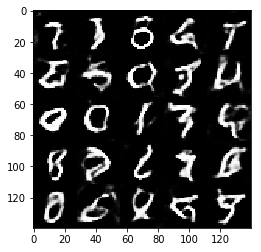

epoch 2/2 *** discriminator loss: 1.0554 *** generator loss: 1.0401
epoch 2/2 *** discriminator loss: 1.2050 *** generator loss: 1.5836
epoch 2/2 *** discriminator loss: 1.1046 *** generator loss: 1.1991
epoch 2/2 *** discriminator loss: 1.1107 *** generator loss: 1.4259
epoch 2/2 *** discriminator loss: 1.1902 *** generator loss: 0.7583
epoch 2/2 *** discriminator loss: 1.2015 *** generator loss: 0.9225
epoch 2/2 *** discriminator loss: 1.1707 *** generator loss: 1.1407
epoch 2/2 *** discriminator loss: 1.2298 *** generator loss: 1.0113
epoch 2/2 *** discriminator loss: 1.5057 *** generator loss: 1.5025
epoch 2/2 *** discriminator loss: 1.1736 *** generator loss: 1.1802
progress: 37%


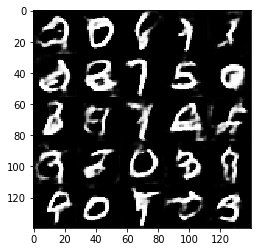

epoch 2/2 *** discriminator loss: 1.3231 *** generator loss: 1.4374
epoch 2/2 *** discriminator loss: 1.3809 *** generator loss: 1.8263
epoch 2/2 *** discriminator loss: 1.0769 *** generator loss: 0.9495
epoch 2/2 *** discriminator loss: 1.4393 *** generator loss: 0.9071
epoch 2/2 *** discriminator loss: 1.2432 *** generator loss: 0.9496
epoch 2/2 *** discriminator loss: 1.2525 *** generator loss: 1.7646
epoch 2/2 *** discriminator loss: 1.2821 *** generator loss: 0.9386
epoch 2/2 *** discriminator loss: 1.0491 *** generator loss: 0.8390
epoch 2/2 *** discriminator loss: 1.2629 *** generator loss: 1.2234
epoch 2/2 *** discriminator loss: 1.2746 *** generator loss: 1.0728
progress: 39%


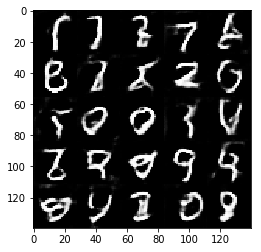

epoch 2/2 *** discriminator loss: 1.0671 *** generator loss: 0.8088
epoch 2/2 *** discriminator loss: 1.1392 *** generator loss: 0.8131
epoch 2/2 *** discriminator loss: 1.2844 *** generator loss: 0.8631
epoch 2/2 *** discriminator loss: 1.2119 *** generator loss: 1.1314
epoch 2/2 *** discriminator loss: 1.1408 *** generator loss: 1.2054
epoch 2/2 *** discriminator loss: 1.1796 *** generator loss: 1.2054
epoch 2/2 *** discriminator loss: 1.2928 *** generator loss: 1.1921
epoch 2/2 *** discriminator loss: 1.3097 *** generator loss: 1.8779
epoch 2/2 *** discriminator loss: 1.3429 *** generator loss: 0.7506
epoch 2/2 *** discriminator loss: 1.3716 *** generator loss: 1.3345
progress: 40%


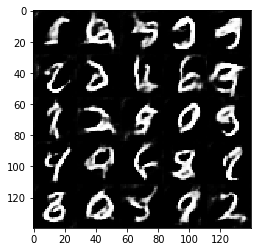

epoch 2/2 *** discriminator loss: 1.1364 *** generator loss: 0.8878
epoch 2/2 *** discriminator loss: 1.2291 *** generator loss: 1.5853
epoch 2/2 *** discriminator loss: 1.0813 *** generator loss: 1.2702
epoch 2/2 *** discriminator loss: 1.0992 *** generator loss: 0.7782
epoch 2/2 *** discriminator loss: 1.2494 *** generator loss: 0.8825
epoch 2/2 *** discriminator loss: 1.4408 *** generator loss: 1.2935
epoch 2/2 *** discriminator loss: 1.3032 *** generator loss: 1.5301
epoch 2/2 *** discriminator loss: 1.2370 *** generator loss: 1.0916
epoch 2/2 *** discriminator loss: 1.1531 *** generator loss: 1.1369
epoch 2/2 *** discriminator loss: 1.3602 *** generator loss: 0.7078
progress: 42%


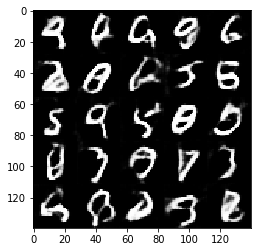

epoch 2/2 *** discriminator loss: 1.1690 *** generator loss: 0.9442
epoch 2/2 *** discriminator loss: 1.1033 *** generator loss: 1.0263
epoch 2/2 *** discriminator loss: 1.1307 *** generator loss: 1.1194
epoch 2/2 *** discriminator loss: 1.1920 *** generator loss: 1.3018
epoch 2/2 *** discriminator loss: 1.2012 *** generator loss: 1.4209
epoch 2/2 *** discriminator loss: 1.3126 *** generator loss: 0.6532
epoch 2/2 *** discriminator loss: 1.0886 *** generator loss: 1.2650
epoch 2/2 *** discriminator loss: 1.1902 *** generator loss: 1.0667
epoch 2/2 *** discriminator loss: 1.3800 *** generator loss: 0.5559
epoch 2/2 *** discriminator loss: 1.2318 *** generator loss: 0.7073
progress: 44%


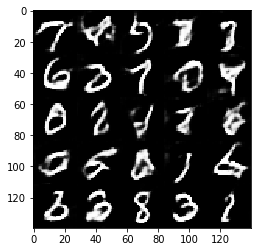

epoch 2/2 *** discriminator loss: 1.3336 *** generator loss: 1.6090
epoch 2/2 *** discriminator loss: 1.0234 *** generator loss: 0.8884
epoch 2/2 *** discriminator loss: 1.3392 *** generator loss: 0.9918
epoch 2/2 *** discriminator loss: 1.1550 *** generator loss: 1.1259
epoch 2/2 *** discriminator loss: 1.3536 *** generator loss: 0.7421
epoch 2/2 *** discriminator loss: 1.0581 *** generator loss: 1.3901
epoch 2/2 *** discriminator loss: 1.1892 *** generator loss: 0.8737
epoch 2/2 *** discriminator loss: 1.2511 *** generator loss: 1.2059
epoch 2/2 *** discriminator loss: 1.1155 *** generator loss: 1.1276
epoch 2/2 *** discriminator loss: 1.1281 *** generator loss: 0.9534
progress: 45%


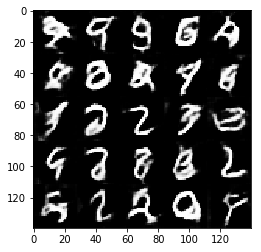

epoch 2/2 *** discriminator loss: 1.2275 *** generator loss: 0.9236
epoch 2/2 *** discriminator loss: 1.0153 *** generator loss: 1.3094
epoch 2/2 *** discriminator loss: 1.1881 *** generator loss: 1.1732
epoch 2/2 *** discriminator loss: 1.0290 *** generator loss: 1.1766
epoch 2/2 *** discriminator loss: 1.2263 *** generator loss: 1.4160
epoch 2/2 *** discriminator loss: 1.1751 *** generator loss: 1.1978
epoch 2/2 *** discriminator loss: 1.0926 *** generator loss: 1.2897
epoch 2/2 *** discriminator loss: 1.3721 *** generator loss: 0.7926
epoch 2/2 *** discriminator loss: 1.0875 *** generator loss: 1.1843
epoch 2/2 *** discriminator loss: 1.1545 *** generator loss: 1.3165
progress: 47%


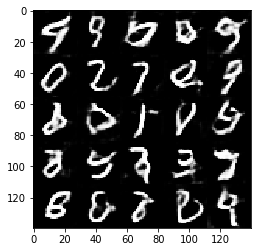

epoch 2/2 *** discriminator loss: 1.1924 *** generator loss: 0.9910
epoch 2/2 *** discriminator loss: 1.3286 *** generator loss: 1.6656
epoch 2/2 *** discriminator loss: 1.3388 *** generator loss: 0.9723
epoch 2/2 *** discriminator loss: 1.1646 *** generator loss: 0.9615
epoch 2/2 *** discriminator loss: 1.0360 *** generator loss: 0.9008
epoch 2/2 *** discriminator loss: 1.4052 *** generator loss: 0.6238
epoch 2/2 *** discriminator loss: 1.1755 *** generator loss: 0.9317
epoch 2/2 *** discriminator loss: 1.4332 *** generator loss: 1.0557
epoch 2/2 *** discriminator loss: 1.0518 *** generator loss: 1.2019
epoch 2/2 *** discriminator loss: 1.3672 *** generator loss: 1.6316
progress: 48%


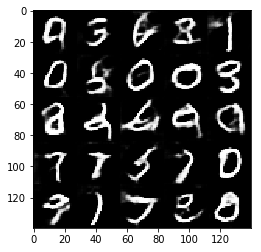

epoch 2/2 *** discriminator loss: 1.4310 *** generator loss: 1.1915
epoch 2/2 *** discriminator loss: 1.1521 *** generator loss: 1.1159
epoch 2/2 *** discriminator loss: 1.2383 *** generator loss: 1.3361
epoch 2/2 *** discriminator loss: 1.0809 *** generator loss: 0.9427
epoch 2/2 *** discriminator loss: 1.3588 *** generator loss: 0.6526
epoch 2/2 *** discriminator loss: 1.2747 *** generator loss: 1.2414
epoch 2/2 *** discriminator loss: 0.9803 *** generator loss: 1.3561
epoch 2/2 *** discriminator loss: 1.0673 *** generator loss: 1.3840
epoch 2/2 *** discriminator loss: 1.1218 *** generator loss: 1.3180
epoch 2/2 *** discriminator loss: 1.1235 *** generator loss: 1.1069
progress: 50%


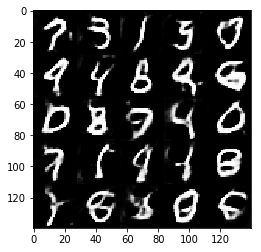

epoch 2/2 *** discriminator loss: 1.2773 *** generator loss: 2.0945
epoch 2/2 *** discriminator loss: 1.0820 *** generator loss: 0.9973
epoch 2/2 *** discriminator loss: 1.1618 *** generator loss: 0.8834
epoch 2/2 *** discriminator loss: 1.2360 *** generator loss: 1.3778
epoch 2/2 *** discriminator loss: 1.0721 *** generator loss: 0.8689
epoch 2/2 *** discriminator loss: 1.0783 *** generator loss: 1.4483
epoch 2/2 *** discriminator loss: 1.1418 *** generator loss: 1.1205
epoch 2/2 *** discriminator loss: 1.2262 *** generator loss: 1.2379
epoch 2/2 *** discriminator loss: 1.2408 *** generator loss: 1.0392
epoch 2/2 *** discriminator loss: 1.1848 *** generator loss: 1.4321
progress: 52%


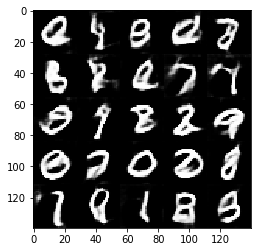

epoch 2/2 *** discriminator loss: 1.1269 *** generator loss: 0.8818
epoch 2/2 *** discriminator loss: 1.1973 *** generator loss: 0.8025
epoch 2/2 *** discriminator loss: 1.1446 *** generator loss: 1.0708
epoch 2/2 *** discriminator loss: 1.2036 *** generator loss: 0.9329
epoch 2/2 *** discriminator loss: 1.1848 *** generator loss: 1.1593
epoch 2/2 *** discriminator loss: 1.2196 *** generator loss: 1.2182
epoch 2/2 *** discriminator loss: 1.2890 *** generator loss: 0.9860
epoch 2/2 *** discriminator loss: 1.0319 *** generator loss: 1.3937
epoch 2/2 *** discriminator loss: 1.1181 *** generator loss: 1.4117
epoch 2/2 *** discriminator loss: 1.1503 *** generator loss: 0.9635
progress: 53%


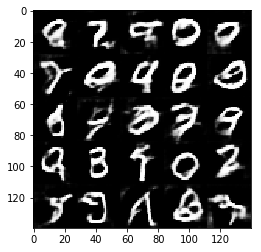

epoch 2/2 *** discriminator loss: 0.9989 *** generator loss: 1.1276
epoch 2/2 *** discriminator loss: 1.1127 *** generator loss: 1.1924
epoch 2/2 *** discriminator loss: 1.1389 *** generator loss: 1.1573
epoch 2/2 *** discriminator loss: 1.1919 *** generator loss: 1.6708
epoch 2/2 *** discriminator loss: 0.9710 *** generator loss: 1.0802
epoch 2/2 *** discriminator loss: 1.3698 *** generator loss: 1.3155
epoch 2/2 *** discriminator loss: 0.9637 *** generator loss: 1.1711
epoch 2/2 *** discriminator loss: 1.3514 *** generator loss: 0.9953
epoch 2/2 *** discriminator loss: 1.2335 *** generator loss: 0.9941
epoch 2/2 *** discriminator loss: 1.1569 *** generator loss: 0.9167
progress: 55%


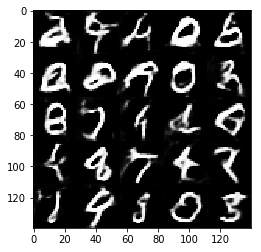

epoch 2/2 *** discriminator loss: 1.3166 *** generator loss: 1.6159
epoch 2/2 *** discriminator loss: 0.9851 *** generator loss: 0.8768
epoch 2/2 *** discriminator loss: 1.1905 *** generator loss: 1.4395
epoch 2/2 *** discriminator loss: 1.0800 *** generator loss: 1.2290
epoch 2/2 *** discriminator loss: 1.2927 *** generator loss: 1.4884
epoch 2/2 *** discriminator loss: 1.0597 *** generator loss: 1.4388
epoch 2/2 *** discriminator loss: 1.1489 *** generator loss: 0.9585
epoch 2/2 *** discriminator loss: 1.2302 *** generator loss: 0.8022
epoch 2/2 *** discriminator loss: 1.2668 *** generator loss: 1.5934
epoch 2/2 *** discriminator loss: 1.2617 *** generator loss: 1.1469
progress: 56%


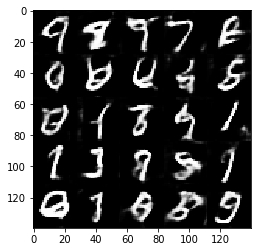

epoch 2/2 *** discriminator loss: 0.9429 *** generator loss: 1.0322
epoch 2/2 *** discriminator loss: 1.3313 *** generator loss: 1.3651
epoch 2/2 *** discriminator loss: 1.0796 *** generator loss: 1.4186
epoch 2/2 *** discriminator loss: 1.3170 *** generator loss: 1.3257
epoch 2/2 *** discriminator loss: 1.1993 *** generator loss: 1.1636
epoch 2/2 *** discriminator loss: 1.3121 *** generator loss: 1.2570
epoch 2/2 *** discriminator loss: 1.0634 *** generator loss: 1.0201
epoch 2/2 *** discriminator loss: 1.2092 *** generator loss: 1.2048
epoch 2/2 *** discriminator loss: 1.1760 *** generator loss: 1.1866
epoch 2/2 *** discriminator loss: 1.3117 *** generator loss: 1.1547
progress: 58%


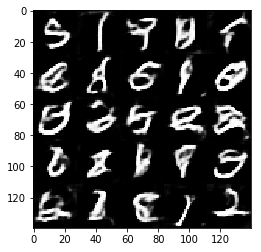

epoch 2/2 *** discriminator loss: 1.4729 *** generator loss: 1.0585
epoch 2/2 *** discriminator loss: 1.2071 *** generator loss: 1.1070
epoch 2/2 *** discriminator loss: 1.2448 *** generator loss: 1.0705
epoch 2/2 *** discriminator loss: 1.0048 *** generator loss: 1.3638
epoch 2/2 *** discriminator loss: 1.3690 *** generator loss: 0.9044
epoch 2/2 *** discriminator loss: 1.2356 *** generator loss: 1.4004
epoch 2/2 *** discriminator loss: 1.2353 *** generator loss: 1.1781
epoch 2/2 *** discriminator loss: 1.3581 *** generator loss: 1.5629
epoch 2/2 *** discriminator loss: 0.9819 *** generator loss: 1.6531
epoch 2/2 *** discriminator loss: 1.1344 *** generator loss: 1.2976
progress: 60%


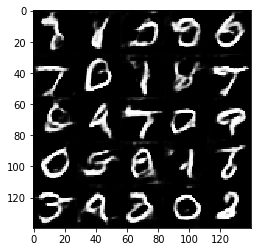

epoch 2/2 *** discriminator loss: 1.1074 *** generator loss: 0.9355
epoch 2/2 *** discriminator loss: 0.9897 *** generator loss: 1.5342
epoch 2/2 *** discriminator loss: 1.3901 *** generator loss: 1.1936
epoch 2/2 *** discriminator loss: 1.2578 *** generator loss: 2.0155
epoch 2/2 *** discriminator loss: 1.2211 *** generator loss: 1.7163
(20, 40)
COMPLETE


In [22]:
batch_size = 32
z_dim = 128
learning_rate = 0.0009
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

epoch 1/1 *** discriminator loss: 1.7166 *** generator loss: 6.0176
epoch 1/1 *** discriminator loss: 1.8230 *** generator loss: 4.8203
epoch 1/1 *** discriminator loss: 1.4507 *** generator loss: 6.3856
epoch 1/1 *** discriminator loss: 1.3640 *** generator loss: 5.7880
epoch 1/1 *** discriminator loss: 0.9961 *** generator loss: 3.7263
epoch 1/1 *** discriminator loss: 2.1505 *** generator loss: 5.3661
epoch 1/1 *** discriminator loss: 0.6555 *** generator loss: 2.4644
epoch 1/1 *** discriminator loss: 0.7365 *** generator loss: 1.5685
epoch 1/1 *** discriminator loss: 0.6744 *** generator loss: 1.9143
epoch 1/1 *** discriminator loss: 0.8950 *** generator loss: 2.7126
progress: 3%


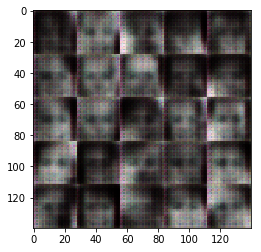

epoch 1/1 *** discriminator loss: 0.7456 *** generator loss: 1.9363
epoch 1/1 *** discriminator loss: 0.7664 *** generator loss: 1.3424
epoch 1/1 *** discriminator loss: 1.2982 *** generator loss: 4.5497
epoch 1/1 *** discriminator loss: 0.8125 *** generator loss: 2.0980
epoch 1/1 *** discriminator loss: 0.9973 *** generator loss: 1.1571
epoch 1/1 *** discriminator loss: 0.6579 *** generator loss: 2.2768
epoch 1/1 *** discriminator loss: 0.8091 *** generator loss: 1.3729
epoch 1/1 *** discriminator loss: 0.8524 *** generator loss: 1.4766
epoch 1/1 *** discriminator loss: 0.9700 *** generator loss: 1.6869
epoch 1/1 *** discriminator loss: 1.3121 *** generator loss: 0.5154
progress: 6%


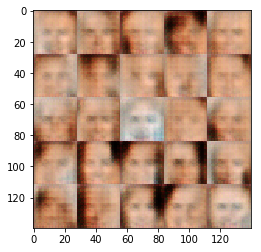

epoch 1/1 *** discriminator loss: 1.2338 *** generator loss: 2.8402
epoch 1/1 *** discriminator loss: 1.5215 *** generator loss: 0.5133
epoch 1/1 *** discriminator loss: 0.8607 *** generator loss: 1.3917
epoch 1/1 *** discriminator loss: 0.7231 *** generator loss: 1.3540
epoch 1/1 *** discriminator loss: 1.0996 *** generator loss: 1.1848
epoch 1/1 *** discriminator loss: 0.8861 *** generator loss: 1.2745
epoch 1/1 *** discriminator loss: 1.0627 *** generator loss: 2.2791
epoch 1/1 *** discriminator loss: 1.2777 *** generator loss: 2.4940
epoch 1/1 *** discriminator loss: 1.6361 *** generator loss: 3.1623
epoch 1/1 *** discriminator loss: 1.2897 *** generator loss: 2.3761
progress: 10%


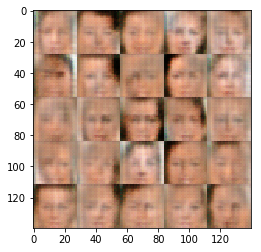

epoch 1/1 *** discriminator loss: 0.9695 *** generator loss: 1.2537
epoch 1/1 *** discriminator loss: 1.5255 *** generator loss: 0.5416
epoch 1/1 *** discriminator loss: 1.1632 *** generator loss: 2.1118
epoch 1/1 *** discriminator loss: 1.1031 *** generator loss: 0.8760
epoch 1/1 *** discriminator loss: 1.0745 *** generator loss: 2.0031
epoch 1/1 *** discriminator loss: 1.3572 *** generator loss: 2.6326
epoch 1/1 *** discriminator loss: 1.8314 *** generator loss: 3.2755
epoch 1/1 *** discriminator loss: 1.2356 *** generator loss: 0.7488
epoch 1/1 *** discriminator loss: 1.2594 *** generator loss: 0.6325
epoch 1/1 *** discriminator loss: 1.1772 *** generator loss: 1.9945
progress: 13%


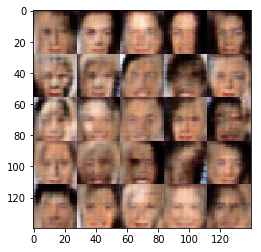

epoch 1/1 *** discriminator loss: 1.2659 *** generator loss: 1.4559
epoch 1/1 *** discriminator loss: 1.7570 *** generator loss: 2.8688
epoch 1/1 *** discriminator loss: 1.0261 *** generator loss: 1.5944
epoch 1/1 *** discriminator loss: 1.1231 *** generator loss: 0.9889
epoch 1/1 *** discriminator loss: 1.3138 *** generator loss: 0.6498
epoch 1/1 *** discriminator loss: 1.1707 *** generator loss: 1.5937
epoch 1/1 *** discriminator loss: 0.9929 *** generator loss: 1.9641
epoch 1/1 *** discriminator loss: 0.9557 *** generator loss: 1.1859
epoch 1/1 *** discriminator loss: 1.2498 *** generator loss: 1.0043
epoch 1/1 *** discriminator loss: 1.2858 *** generator loss: 2.0120
progress: 16%


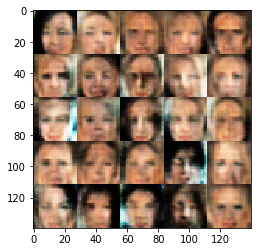

epoch 1/1 *** discriminator loss: 1.4707 *** generator loss: 2.0302
epoch 1/1 *** discriminator loss: 1.1101 *** generator loss: 1.3879
epoch 1/1 *** discriminator loss: 1.0699 *** generator loss: 0.9479
epoch 1/1 *** discriminator loss: 1.0567 *** generator loss: 1.2481
epoch 1/1 *** discriminator loss: 1.0574 *** generator loss: 0.8879
epoch 1/1 *** discriminator loss: 1.0363 *** generator loss: 1.1836
epoch 1/1 *** discriminator loss: 1.2826 *** generator loss: 0.7176
epoch 1/1 *** discriminator loss: 1.5245 *** generator loss: 2.6777
epoch 1/1 *** discriminator loss: 1.1104 *** generator loss: 0.9872
epoch 1/1 *** discriminator loss: 1.3553 *** generator loss: 0.6018
progress: 19%


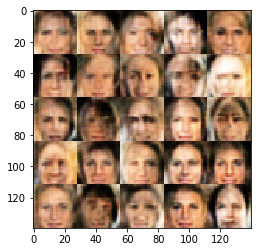

epoch 1/1 *** discriminator loss: 1.1854 *** generator loss: 1.3924
epoch 1/1 *** discriminator loss: 1.1611 *** generator loss: 1.3196
epoch 1/1 *** discriminator loss: 1.1746 *** generator loss: 2.0732
epoch 1/1 *** discriminator loss: 1.1689 *** generator loss: 1.0282
epoch 1/1 *** discriminator loss: 1.2003 *** generator loss: 0.8210
epoch 1/1 *** discriminator loss: 1.2122 *** generator loss: 0.9423
epoch 1/1 *** discriminator loss: 1.2819 *** generator loss: 0.6561
epoch 1/1 *** discriminator loss: 1.2582 *** generator loss: 0.6364
epoch 1/1 *** discriminator loss: 1.3702 *** generator loss: 0.5961
epoch 1/1 *** discriminator loss: 1.0929 *** generator loss: 0.9666
progress: 23%


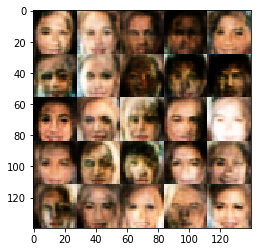

epoch 1/1 *** discriminator loss: 1.3360 *** generator loss: 0.7980
epoch 1/1 *** discriminator loss: 1.2457 *** generator loss: 0.6320
epoch 1/1 *** discriminator loss: 1.2393 *** generator loss: 0.6917
epoch 1/1 *** discriminator loss: 1.2406 *** generator loss: 1.5003
epoch 1/1 *** discriminator loss: 1.5850 *** generator loss: 1.8579
epoch 1/1 *** discriminator loss: 1.2073 *** generator loss: 1.1060
epoch 1/1 *** discriminator loss: 1.2787 *** generator loss: 0.8158
epoch 1/1 *** discriminator loss: 1.1736 *** generator loss: 1.5904
epoch 1/1 *** discriminator loss: 1.4303 *** generator loss: 1.7138
epoch 1/1 *** discriminator loss: 1.2327 *** generator loss: 1.5361
progress: 26%


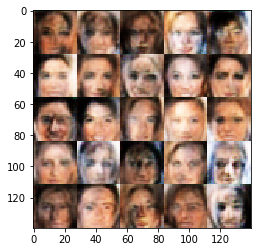

epoch 1/1 *** discriminator loss: 1.3253 *** generator loss: 1.6782
epoch 1/1 *** discriminator loss: 1.2783 *** generator loss: 1.6042
epoch 1/1 *** discriminator loss: 1.2514 *** generator loss: 0.7856
epoch 1/1 *** discriminator loss: 1.2926 *** generator loss: 1.6410
epoch 1/1 *** discriminator loss: 1.2951 *** generator loss: 1.2605
epoch 1/1 *** discriminator loss: 1.2324 *** generator loss: 1.3916
epoch 1/1 *** discriminator loss: 1.2775 *** generator loss: 1.1111
epoch 1/1 *** discriminator loss: 1.2307 *** generator loss: 1.2736
epoch 1/1 *** discriminator loss: 1.2900 *** generator loss: 1.1311
epoch 1/1 *** discriminator loss: 1.2852 *** generator loss: 0.8369
progress: 29%


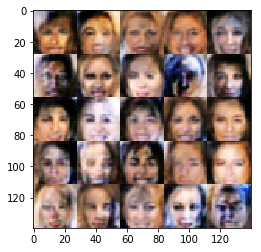

epoch 1/1 *** discriminator loss: 1.4995 *** generator loss: 0.5832
epoch 1/1 *** discriminator loss: 1.3606 *** generator loss: 1.5243
epoch 1/1 *** discriminator loss: 1.2842 *** generator loss: 1.2076
epoch 1/1 *** discriminator loss: 1.2804 *** generator loss: 0.6669
epoch 1/1 *** discriminator loss: 1.3971 *** generator loss: 0.5331
epoch 1/1 *** discriminator loss: 1.2621 *** generator loss: 1.1282
epoch 1/1 *** discriminator loss: 1.1493 *** generator loss: 1.0711
epoch 1/1 *** discriminator loss: 1.3440 *** generator loss: 0.6259
epoch 1/1 *** discriminator loss: 1.1876 *** generator loss: 0.9164
epoch 1/1 *** discriminator loss: 1.3682 *** generator loss: 0.9203
progress: 32%


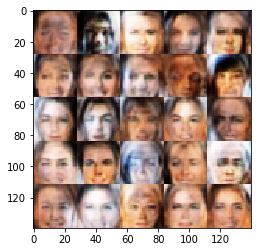

epoch 1/1 *** discriminator loss: 1.3620 *** generator loss: 0.7469
epoch 1/1 *** discriminator loss: 1.3781 *** generator loss: 0.6531
epoch 1/1 *** discriminator loss: 1.2407 *** generator loss: 1.1673
epoch 1/1 *** discriminator loss: 1.1549 *** generator loss: 1.0451
epoch 1/1 *** discriminator loss: 1.3442 *** generator loss: 0.9794
epoch 1/1 *** discriminator loss: 1.2943 *** generator loss: 1.3162
epoch 1/1 *** discriminator loss: 1.2336 *** generator loss: 0.8136
epoch 1/1 *** discriminator loss: 1.1876 *** generator loss: 1.0517
epoch 1/1 *** discriminator loss: 1.3996 *** generator loss: 1.1813
epoch 1/1 *** discriminator loss: 1.2441 *** generator loss: 0.7454
progress: 35%


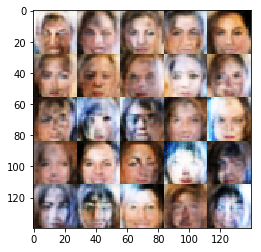

epoch 1/1 *** discriminator loss: 1.3616 *** generator loss: 1.3862
epoch 1/1 *** discriminator loss: 1.2789 *** generator loss: 1.2159
epoch 1/1 *** discriminator loss: 1.2294 *** generator loss: 1.0052
epoch 1/1 *** discriminator loss: 1.4348 *** generator loss: 1.2164
epoch 1/1 *** discriminator loss: 1.2200 *** generator loss: 0.8518
epoch 1/1 *** discriminator loss: 1.3133 *** generator loss: 0.6421
epoch 1/1 *** discriminator loss: 1.2384 *** generator loss: 0.8638
epoch 1/1 *** discriminator loss: 1.3275 *** generator loss: 0.8980
epoch 1/1 *** discriminator loss: 1.3774 *** generator loss: 1.5001
epoch 1/1 *** discriminator loss: 1.2713 *** generator loss: 0.8095
progress: 39%


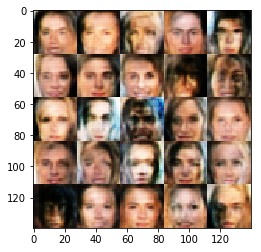

epoch 1/1 *** discriminator loss: 1.4278 *** generator loss: 1.4397
epoch 1/1 *** discriminator loss: 1.1860 *** generator loss: 1.0756
epoch 1/1 *** discriminator loss: 1.1620 *** generator loss: 0.9886
epoch 1/1 *** discriminator loss: 1.2880 *** generator loss: 1.0416
epoch 1/1 *** discriminator loss: 1.3839 *** generator loss: 1.3754
epoch 1/1 *** discriminator loss: 1.2291 *** generator loss: 1.1338
epoch 1/1 *** discriminator loss: 1.2970 *** generator loss: 0.8924
epoch 1/1 *** discriminator loss: 1.4522 *** generator loss: 1.7651
epoch 1/1 *** discriminator loss: 1.2337 *** generator loss: 1.1338
epoch 1/1 *** discriminator loss: 1.2262 *** generator loss: 0.8181
progress: 42%


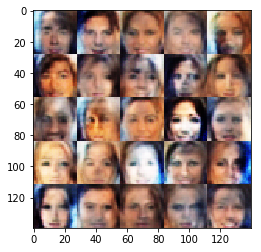

epoch 1/1 *** discriminator loss: 1.3856 *** generator loss: 1.0028
epoch 1/1 *** discriminator loss: 1.4059 *** generator loss: 1.4086
epoch 1/1 *** discriminator loss: 1.3839 *** generator loss: 0.8731
epoch 1/1 *** discriminator loss: 1.1847 *** generator loss: 0.9139
epoch 1/1 *** discriminator loss: 1.4328 *** generator loss: 0.5904
epoch 1/1 *** discriminator loss: 1.1136 *** generator loss: 1.0017
epoch 1/1 *** discriminator loss: 1.1692 *** generator loss: 1.2045
epoch 1/1 *** discriminator loss: 1.2791 *** generator loss: 0.5900
epoch 1/1 *** discriminator loss: 1.3578 *** generator loss: 0.8326
epoch 1/1 *** discriminator loss: 1.3273 *** generator loss: 0.9832
progress: 45%


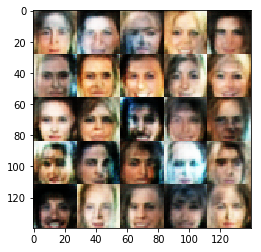

epoch 1/1 *** discriminator loss: 1.1520 *** generator loss: 1.0121
epoch 1/1 *** discriminator loss: 1.2640 *** generator loss: 1.2905
epoch 1/1 *** discriminator loss: 1.2234 *** generator loss: 0.7595
epoch 1/1 *** discriminator loss: 1.2305 *** generator loss: 0.8240
epoch 1/1 *** discriminator loss: 1.2610 *** generator loss: 0.8204
epoch 1/1 *** discriminator loss: 1.1451 *** generator loss: 1.0092
epoch 1/1 *** discriminator loss: 1.2606 *** generator loss: 1.6065
epoch 1/1 *** discriminator loss: 1.4297 *** generator loss: 1.2073
epoch 1/1 *** discriminator loss: 1.3981 *** generator loss: 0.6559
epoch 1/1 *** discriminator loss: 1.2999 *** generator loss: 0.8050
progress: 48%


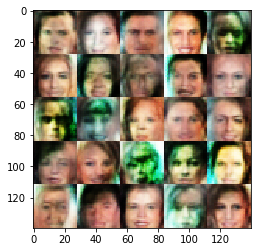

epoch 1/1 *** discriminator loss: 1.1824 *** generator loss: 0.9723
epoch 1/1 *** discriminator loss: 1.2654 *** generator loss: 1.0379
epoch 1/1 *** discriminator loss: 1.3111 *** generator loss: 1.1004
epoch 1/1 *** discriminator loss: 1.1059 *** generator loss: 1.2806
epoch 1/1 *** discriminator loss: 1.2703 *** generator loss: 0.9461
epoch 1/1 *** discriminator loss: 1.3277 *** generator loss: 0.9331
epoch 1/1 *** discriminator loss: 1.3824 *** generator loss: 1.2955
epoch 1/1 *** discriminator loss: 1.3674 *** generator loss: 1.2034
epoch 1/1 *** discriminator loss: 1.2458 *** generator loss: 1.1415
epoch 1/1 *** discriminator loss: 1.2610 *** generator loss: 1.0690
progress: 52%


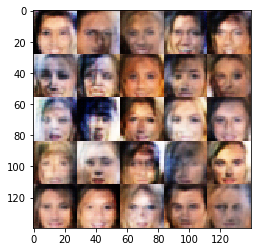

epoch 1/1 *** discriminator loss: 1.3454 *** generator loss: 1.2436
epoch 1/1 *** discriminator loss: 1.3524 *** generator loss: 1.4250
epoch 1/1 *** discriminator loss: 1.3077 *** generator loss: 0.7807
epoch 1/1 *** discriminator loss: 1.2290 *** generator loss: 0.7823
epoch 1/1 *** discriminator loss: 1.2166 *** generator loss: 1.2067
epoch 1/1 *** discriminator loss: 1.2635 *** generator loss: 0.7994
epoch 1/1 *** discriminator loss: 1.2993 *** generator loss: 1.2701
epoch 1/1 *** discriminator loss: 1.3197 *** generator loss: 1.4517
epoch 1/1 *** discriminator loss: 1.2659 *** generator loss: 1.3468
epoch 1/1 *** discriminator loss: 1.2598 *** generator loss: 0.7728
progress: 55%


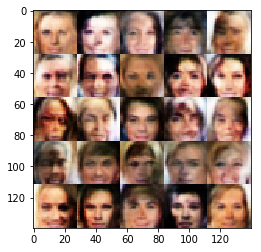

epoch 1/1 *** discriminator loss: 1.2109 *** generator loss: 1.1155
epoch 1/1 *** discriminator loss: 1.3460 *** generator loss: 0.6264
epoch 1/1 *** discriminator loss: 1.3772 *** generator loss: 1.1768
epoch 1/1 *** discriminator loss: 1.3319 *** generator loss: 0.9697
epoch 1/1 *** discriminator loss: 1.2548 *** generator loss: 1.1282
epoch 1/1 *** discriminator loss: 1.2564 *** generator loss: 0.7453
epoch 1/1 *** discriminator loss: 1.2698 *** generator loss: 1.0223
epoch 1/1 *** discriminator loss: 1.1381 *** generator loss: 1.0644
epoch 1/1 *** discriminator loss: 1.2894 *** generator loss: 0.8987
epoch 1/1 *** discriminator loss: 1.2658 *** generator loss: 0.6121
progress: 58%


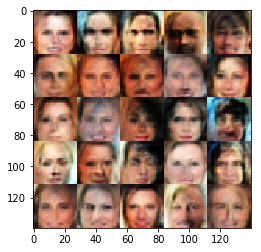

epoch 1/1 *** discriminator loss: 1.2517 *** generator loss: 1.1045
epoch 1/1 *** discriminator loss: 1.3326 *** generator loss: 1.4253
epoch 1/1 *** discriminator loss: 1.2797 *** generator loss: 1.4213
epoch 1/1 *** discriminator loss: 1.2887 *** generator loss: 1.2460
epoch 1/1 *** discriminator loss: 1.1962 *** generator loss: 0.9325
epoch 1/1 *** discriminator loss: 1.2453 *** generator loss: 1.2408
epoch 1/1 *** discriminator loss: 1.2690 *** generator loss: 1.4870
epoch 1/1 *** discriminator loss: 1.3241 *** generator loss: 0.9691
epoch 1/1 *** discriminator loss: 1.2146 *** generator loss: 1.0674
epoch 1/1 *** discriminator loss: 1.3382 *** generator loss: 0.6933
progress: 61%


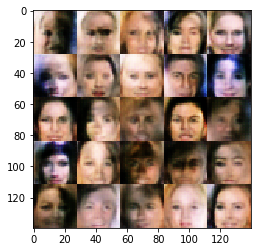

epoch 1/1 *** discriminator loss: 1.2917 *** generator loss: 1.1092
epoch 1/1 *** discriminator loss: 1.2215 *** generator loss: 0.8466
epoch 1/1 *** discriminator loss: 1.2987 *** generator loss: 1.2764
epoch 1/1 *** discriminator loss: 1.1698 *** generator loss: 1.1430
epoch 1/1 *** discriminator loss: 1.1990 *** generator loss: 0.8243
epoch 1/1 *** discriminator loss: 1.2527 *** generator loss: 0.7491
epoch 1/1 *** discriminator loss: 1.5013 *** generator loss: 1.6902
epoch 1/1 *** discriminator loss: 1.4397 *** generator loss: 1.2851
epoch 1/1 *** discriminator loss: 1.3538 *** generator loss: 0.9220
epoch 1/1 *** discriminator loss: 1.3156 *** generator loss: 1.0043
progress: 65%


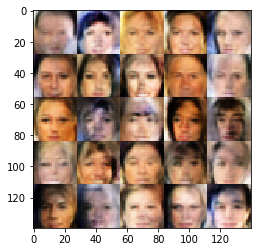

epoch 1/1 *** discriminator loss: 1.4453 *** generator loss: 1.6619
epoch 1/1 *** discriminator loss: 1.2404 *** generator loss: 0.9174
epoch 1/1 *** discriminator loss: 1.1738 *** generator loss: 1.0062
epoch 1/1 *** discriminator loss: 1.3465 *** generator loss: 1.3021
epoch 1/1 *** discriminator loss: 1.2418 *** generator loss: 0.9694
epoch 1/1 *** discriminator loss: 1.1699 *** generator loss: 1.1863
epoch 1/1 *** discriminator loss: 1.2638 *** generator loss: 0.6342
epoch 1/1 *** discriminator loss: 1.1725 *** generator loss: 0.8441
epoch 1/1 *** discriminator loss: 1.3095 *** generator loss: 0.7971
epoch 1/1 *** discriminator loss: 1.2320 *** generator loss: 1.0276
progress: 68%


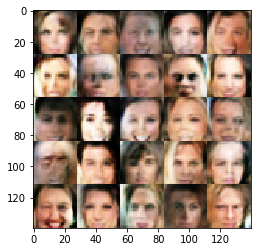

epoch 1/1 *** discriminator loss: 1.3007 *** generator loss: 0.9019
epoch 1/1 *** discriminator loss: 1.1828 *** generator loss: 1.0670
epoch 1/1 *** discriminator loss: 1.2800 *** generator loss: 1.0075
epoch 1/1 *** discriminator loss: 1.2205 *** generator loss: 1.1636
epoch 1/1 *** discriminator loss: 1.3450 *** generator loss: 1.0456
epoch 1/1 *** discriminator loss: 1.1590 *** generator loss: 1.0268
epoch 1/1 *** discriminator loss: 1.1683 *** generator loss: 0.9014
epoch 1/1 *** discriminator loss: 1.3471 *** generator loss: 0.7445
epoch 1/1 *** discriminator loss: 1.2617 *** generator loss: 0.9537
epoch 1/1 *** discriminator loss: 1.1894 *** generator loss: 1.1363
progress: 71%


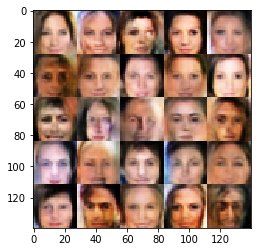

epoch 1/1 *** discriminator loss: 1.2473 *** generator loss: 1.1255
epoch 1/1 *** discriminator loss: 1.2913 *** generator loss: 1.4246
epoch 1/1 *** discriminator loss: 1.2280 *** generator loss: 0.9924
epoch 1/1 *** discriminator loss: 1.2638 *** generator loss: 1.0652
epoch 1/1 *** discriminator loss: 1.3007 *** generator loss: 0.8646
epoch 1/1 *** discriminator loss: 1.3859 *** generator loss: 1.0401
epoch 1/1 *** discriminator loss: 1.3118 *** generator loss: 0.9211
epoch 1/1 *** discriminator loss: 1.3110 *** generator loss: 0.8244
epoch 1/1 *** discriminator loss: 1.3178 *** generator loss: 0.9328
epoch 1/1 *** discriminator loss: 1.2803 *** generator loss: 1.1780
progress: 74%


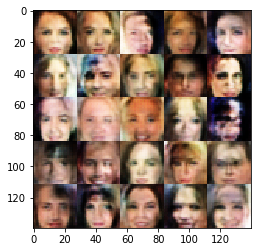

epoch 1/1 *** discriminator loss: 1.2780 *** generator loss: 0.7923
epoch 1/1 *** discriminator loss: 1.3788 *** generator loss: 1.0253
epoch 1/1 *** discriminator loss: 1.3464 *** generator loss: 1.0676
epoch 1/1 *** discriminator loss: 1.1801 *** generator loss: 0.8859
epoch 1/1 *** discriminator loss: 1.2921 *** generator loss: 0.7736
epoch 1/1 *** discriminator loss: 1.1902 *** generator loss: 1.1068
epoch 1/1 *** discriminator loss: 1.1836 *** generator loss: 1.0447
epoch 1/1 *** discriminator loss: 1.2186 *** generator loss: 0.8642
epoch 1/1 *** discriminator loss: 1.2864 *** generator loss: 1.0503
epoch 1/1 *** discriminator loss: 1.2788 *** generator loss: 0.8363
progress: 77%


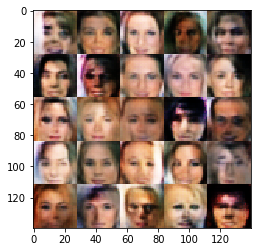

epoch 1/1 *** discriminator loss: 1.2959 *** generator loss: 0.7450
epoch 1/1 *** discriminator loss: 1.2706 *** generator loss: 0.9616
epoch 1/1 *** discriminator loss: 1.3723 *** generator loss: 1.0248
epoch 1/1 *** discriminator loss: 1.1552 *** generator loss: 0.8760
epoch 1/1 *** discriminator loss: 1.4205 *** generator loss: 1.5109
epoch 1/1 *** discriminator loss: 1.2489 *** generator loss: 0.9325
epoch 1/1 *** discriminator loss: 1.2087 *** generator loss: 1.0444
epoch 1/1 *** discriminator loss: 1.2946 *** generator loss: 1.1215
epoch 1/1 *** discriminator loss: 1.3687 *** generator loss: 0.7896
epoch 1/1 *** discriminator loss: 1.2045 *** generator loss: 0.7753
progress: 81%


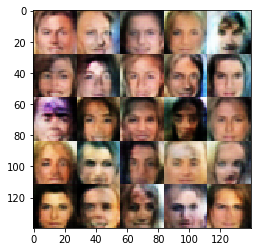

epoch 1/1 *** discriminator loss: 1.1496 *** generator loss: 1.0266
epoch 1/1 *** discriminator loss: 1.2174 *** generator loss: 0.8609
epoch 1/1 *** discriminator loss: 1.2898 *** generator loss: 1.2608
epoch 1/1 *** discriminator loss: 1.2800 *** generator loss: 0.8945
epoch 1/1 *** discriminator loss: 1.2906 *** generator loss: 0.8543
epoch 1/1 *** discriminator loss: 1.3915 *** generator loss: 0.9071
epoch 1/1 *** discriminator loss: 1.2129 *** generator loss: 0.8318
epoch 1/1 *** discriminator loss: 1.4139 *** generator loss: 1.3732
epoch 1/1 *** discriminator loss: 1.3491 *** generator loss: 1.2309
epoch 1/1 *** discriminator loss: 1.2341 *** generator loss: 0.8673
progress: 84%


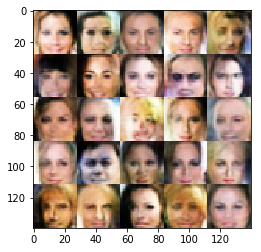

epoch 1/1 *** discriminator loss: 1.3580 *** generator loss: 1.1021
epoch 1/1 *** discriminator loss: 1.2677 *** generator loss: 0.7591
epoch 1/1 *** discriminator loss: 1.2052 *** generator loss: 0.8778
epoch 1/1 *** discriminator loss: 1.3798 *** generator loss: 0.9565
epoch 1/1 *** discriminator loss: 1.2064 *** generator loss: 1.1804
epoch 1/1 *** discriminator loss: 1.3649 *** generator loss: 0.7985
epoch 1/1 *** discriminator loss: 1.2491 *** generator loss: 0.9709
epoch 1/1 *** discriminator loss: 1.3016 *** generator loss: 0.7727
epoch 1/1 *** discriminator loss: 1.2297 *** generator loss: 1.0857
epoch 1/1 *** discriminator loss: 1.2937 *** generator loss: 0.9443
progress: 87%


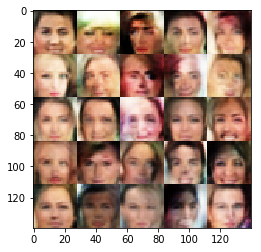

epoch 1/1 *** discriminator loss: 1.2319 *** generator loss: 1.0146
epoch 1/1 *** discriminator loss: 1.2450 *** generator loss: 0.9851
epoch 1/1 *** discriminator loss: 1.2459 *** generator loss: 0.9386
epoch 1/1 *** discriminator loss: 1.2580 *** generator loss: 1.1481
epoch 1/1 *** discriminator loss: 1.1453 *** generator loss: 1.1014
epoch 1/1 *** discriminator loss: 1.3346 *** generator loss: 0.7007
epoch 1/1 *** discriminator loss: 1.3017 *** generator loss: 0.7733
epoch 1/1 *** discriminator loss: 1.2481 *** generator loss: 1.0741
epoch 1/1 *** discriminator loss: 1.2272 *** generator loss: 1.2468
epoch 1/1 *** discriminator loss: 1.3238 *** generator loss: 0.8846
progress: 90%


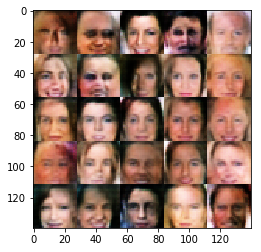

epoch 1/1 *** discriminator loss: 1.2444 *** generator loss: 0.7981
epoch 1/1 *** discriminator loss: 1.2435 *** generator loss: 0.9311
epoch 1/1 *** discriminator loss: 1.2808 *** generator loss: 1.1203
epoch 1/1 *** discriminator loss: 1.2754 *** generator loss: 0.8501
epoch 1/1 *** discriminator loss: 1.2956 *** generator loss: 1.2964
epoch 1/1 *** discriminator loss: 1.3030 *** generator loss: 1.0192
epoch 1/1 *** discriminator loss: 1.2341 *** generator loss: 0.8200
epoch 1/1 *** discriminator loss: 1.3391 *** generator loss: 0.8745
epoch 1/1 *** discriminator loss: 1.2891 *** generator loss: 0.9207
epoch 1/1 *** discriminator loss: 1.3154 *** generator loss: 0.9033
progress: 94%


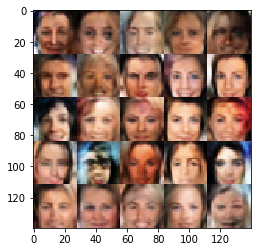

epoch 1/1 *** discriminator loss: 1.2650 *** generator loss: 0.7619
epoch 1/1 *** discriminator loss: 1.1303 *** generator loss: 1.0409
epoch 1/1 *** discriminator loss: 1.2789 *** generator loss: 0.8431
epoch 1/1 *** discriminator loss: 1.2726 *** generator loss: 0.8705
epoch 1/1 *** discriminator loss: 1.2159 *** generator loss: 1.0772
epoch 1/1 *** discriminator loss: 1.3713 *** generator loss: 1.2110
epoch 1/1 *** discriminator loss: 1.3254 *** generator loss: 1.0204
epoch 1/1 *** discriminator loss: 1.2497 *** generator loss: 0.9927
epoch 1/1 *** discriminator loss: 1.1809 *** generator loss: 0.9345
epoch 1/1 *** discriminator loss: 1.2267 *** generator loss: 1.0956
progress: 97%


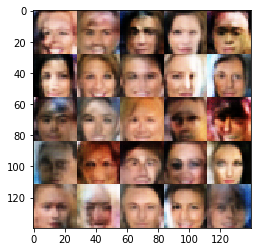

epoch 1/1 *** discriminator loss: 1.2075 *** generator loss: 0.9575
epoch 1/1 *** discriminator loss: 1.2644 *** generator loss: 0.8037
epoch 1/1 *** discriminator loss: 1.2752 *** generator loss: 0.9973
epoch 1/1 *** discriminator loss: 1.1966 *** generator loss: 0.7654
epoch 1/1 *** discriminator loss: 1.2263 *** generator loss: 0.9916
epoch 1/1 *** discriminator loss: 1.3389 *** generator loss: 1.4272
epoch 1/1 *** discriminator loss: 1.2637 *** generator loss: 1.1120
epoch 1/1 *** discriminator loss: 1.2278 *** generator loss: 0.8401
epoch 1/1 *** discriminator loss: 1.3689 *** generator loss: 0.8358
epoch 1/1 *** discriminator loss: 1.1625 *** generator loss: 1.0204
progress: 100%


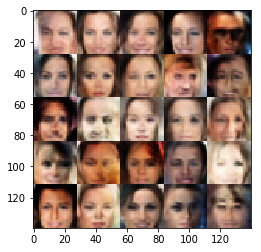

epoch 1/1 *** discriminator loss: 1.2622 *** generator loss: 0.8783
epoch 1/1 *** discriminator loss: 1.2585 *** generator loss: 0.8519
epoch 1/1 *** discriminator loss: 1.3048 *** generator loss: 0.7980
epoch 1/1 *** discriminator loss: 1.2421 *** generator loss: 0.7750
epoch 1/1 *** discriminator loss: 1.2122 *** generator loss: 1.1368
epoch 1/1 *** discriminator loss: 1.2352 *** generator loss: 0.6796
(45, 45)
COMPLETE


In [ ]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.